In [ ]:
!pip install gpytorch
!pip install botorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: linear-operator
    Found existing installation: linear-operator 0.5.0
    Uninstalling linear-operator-0.5.0:
      Successfully uninstalled linear-operator-0.5.0
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.11
    Uninstalling gpytorch-1.11:
      Successfully uninstalled gpytorch-1.11


In [ ]:
import os

import torch
from torch.quasirandom import SobolEngine

from botorch.optim import optimize_acqf
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import ModelList

from botorch.test_functions import Branin
from botorch.test_functions import Hartmann
from botorch.test_functions import Cosine8

In [ ]:
tkwargs = {
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

In [ ]:
beta = 1.0
penalty_weight = 1000
BO_iter = 30
num_restarts = 10
raw_samples = 1024
maxiter = 500
GP_iter = 200
learning_rate = 0.1
n_init = 10

In [ ]:
#objective info
dim_list = [2]
name_list = ["Branin"]
objective_list = [0.397887]
plot_bounds = [[0, 5]]
#cosine's objective is maximum, no need to negate it
negate_list = [-1.0]

In [ ]:
#Branin
branin = Branin(negate = True).to(**tkwargs)

def objective1(x):
  lb, ub = branin.bounds
  return branin(lb + (ub - lb) * x[..., :2])

In [ ]:
objective = [objective1]

In [ ]:
def compute_grad(x, objective):
  num_points, dimensions = x.shape
  epsilon = 0.01
  grad = torch.zeros(num_points, dimensions)
  for i in range(dimensions):
    x_upper = x.clone()
    x_upper[:, i] += epsilon
    x_lower = x.clone()
    x_lower[:, i] -= epsilon
    grad[:, i] = (objective(x_upper) - objective(x_lower)) / (2 * epsilon)
  return grad

In [ ]:
import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from botorch.models import ModelListGP
from botorch.models.higher_order_gp import FlattenedStandardize
from botorch.models.transforms import Normalize, Standardize
from botorch.models import HigherOrderGP, SingleTaskGP
from gpytorch.constraints import Interval
from botorch.optim.fit import fit_gpytorch_mll_torch
from botorch import fit_gpytorch_model

# train model function

def train_single_model(X, Y, nu=1.5, noiseless_obs=True):
  # make sure training data has the right dimension
  if Y.ndim == 1:
      Y = Y.unsqueeze(-1)
  # outcome transform
  standardize = Standardize(m=Y.shape[-1], batch_shape=Y.shape[:-2])
  outcome_transform = standardize
  # covariance module
  covar_module = ScaleKernel(MaternKernel(nu=nu, ard_num_dims=X.shape[-1]))
  # likelihood
  if noiseless_obs:
      _, aug_batch_shape = SingleTaskGP.get_batch_dimensions(
          train_X=X,
          train_Y=Y,
      )
      likelihood = GaussianLikelihood(
          batch_shape=aug_batch_shape,
          noise_constraint=Interval(lower_bound=1e-4, upper_bound=1e-3),
      )
  else:
      likelihood = None
  # define the model
  model = SingleTaskGP(
      train_X=X,
      train_Y=Y,
      covar_module=covar_module,
      likelihood=likelihood,
      outcome_transform=outcome_transform,
  )

  # call the training procedure
  model.outcome_transform.eval()
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  fit_gpytorch_model(mll)
  # put in eval mode
  model.eval()
  # return the model
  return model

def train_model(X, Y, nu=2.5, noiseless_obs=True):
  model_list = []
  noutput = Y.shape[1]
  for i in range(noutput):
    model_i = train_single_model(X, Y[:,i], nu=nu, noiseless_obs=noiseless_obs)
    model_list += [model_i]
  #model = ModelListGP(*model_list)
  return model_list

def get_posterior_stats(model, point):
  """Get the mean and standard deviation of the model's posterior at a given point."""
  #model_grad = self.model_all[1:]
  #model_grad[dim].eval()
  model.eval()
  #cur_points.requires_grad_ = True
  with torch.enable_grad():
    posterior = model.posterior(point)
    mean = posterior.mean
    std_dev = posterior.variance.sqrt()
  return mean, std_dev

In [ ]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.utils import t_batch_mode_transform
from torch import Tensor

class ConstrainedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: ModelList,
        beta: 1.0,
        penalty_weight = 100,
    ) -> None:
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.model_list_new = model_list_new
        self.beta = beta
        self.penalty_weight = penalty_weight
        #self.register_buffer("beta", torch.as_tensor(beta))
        #self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, x: Tensor) -> Tensor:
        means, std_devs = get_posterior_stats(self.model_list_new, x) #b x q x d (q=1)
        means = means.squeeze() #b x d (removes q)
        std_devs = std_devs.squeeze() #b x d
        UCB = means[:, 0] + self.beta * std_devs[:, 0] # b
        constraint_violation = torch.abs(means[:, 1:]) - self.beta * std_devs[:, 1:] #b x (d - 1) -> first dimension mean removed
        constraint_violation = constraint_violation.unsqueeze(-1) #b x (d-1) x 1
        zero = torch.zeros(constraint_violation.shape) #b x (d-1) x 1
        constraint_penalty = torch.sum(torch.max(constraint_violation, zero) ** 2, dim = 1).squeeze(-1) #b
        result = UCB - self.penalty_weight * constraint_penalty # b
        return result

tensor([ -55.8682, -171.0264], dtype=torch.float64, grad_fn=<SliceBackward0>)
tensor([[ -55.8682, -171.0264],
        [ -48.0640,   40.2211],
        [ 278.0478, -317.8761],
        [ 622.1166,  254.1276],
        [-471.1180, -161.1691],
        [ 202.0139, -138.3090],
        [ -23.7852, -279.6672],
        [ 153.4637,  116.6714],
        [-346.7086, -115.2979],
        [-146.9692, -117.7372]], dtype=torch.float64, grad_fn=<SliceBackward0>)
tensor([[3.1550, 1.4618],
        [3.1550, 1.4825],
        [3.1551, 1.7188],
        [3.1551, 1.7372],
        [3.1546, 1.5014],
        [3.1550, 1.5939],
        [3.1549, 1.5489],
        [3.1550, 1.5729],
        [3.1545, 1.1315],
        [3.1547, 1.1070]], dtype=torch.float64, grad_fn=<SliceBackward0>)


In [ ]:
#create 4D torch tensor to store Y values (#trials to avg x #test problems x #BO methods x #BO iterations)
num_avg_trials = 5
test_problems_names = ["EI", "UCB", "KKT"]
num_test_problems = len(dim_list)
num_BO_methods = len(test_problems_names)

Y_all = torch.zeros((num_avg_trials, num_test_problems, num_BO_methods, BO_iter))

In [ ]:
def optimize_AF(acq_func, bounds, q = 1, num_restarts = num_restarts, raw_samples = raw_samples, maxiter = maxiter):
  candidate, acq_value = optimize_acqf(
            acq_function = acq_func,
            bounds = bounds,
            #torch.cat((torch.zeros(1, dim), torch.ones(1, dim))).to(**tkwargs),
            #batch_limit = 1,
            q = q,  # number of candidates to generate (1 for single-point optimization)
            num_restarts = num_restarts,  # number of starting points for multistart optimization
            raw_samples = raw_samples,  # number of samples for initialization heuristic
            options = {"maxiter": maxiter},
            sequential = True,  # use sequential optimization
  )
  return candidate, acq_value

In [ ]:
def update_vanilla(X, Y, candidate, name):
  X = torch.vstack((X, candidate))
  Y_mean_new = objective[i](candidate)
  Y = torch.vstack((Y, Y_mean_new))
  print(f"{name}, Best value: {negate_list[i] * Y.max().item()}, X: {candidate}, Y: {negate_list[i] * Y_mean_new.item()}")
  return X, Y


Branin, Trial: 1, Iteration: 1
EI, Best value: 3.5451956715421797, X: tensor([[0.8280, 0.0393]], dtype=torch.float64), Y: 14.544102668163077
UCB, Best value: 3.5451956715421797, X: tensor([[0.8178, 0.0395]], dtype=torch.float64), Y: 15.75733649109408


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.8128, 0.0767]], dtype=torch.float64) AF:  tensor(11.6980, dtype=torch.float64) , Y:  15.913612548181336 , Y grad GP:  tensor([-88.9741,  -2.5442], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-112.4355,   -2.5323])

Branin, Trial: 1, Iteration: 2
EI, Best value: 1.9457079652477507, X: tensor([[1.0000, 0.2036]], dtype=torch.float64), Y: 1.9457079652477507
UCB, Best value: 3.5451956715421797, X: tensor([[0.4862, 0.0000]], dtype=torch.float64), Y: 12.835631162492636


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  1.2025223957027222 , X:  tensor([[0.5153, 0.1724]], dtype=torch.float64) AF:  tensor(-0.7023, dtype=torch.float64) , Y:  1.2025223957027222 , Y grad GP:  tensor([ 8.1036, -0.9087], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-58.4160,  -0.9886])

Branin, Trial: 1, Iteration: 3
EI, Best value: 1.9457079652477507, X: tensor([[1., 0.]], dtype=torch.float64), Y: 10.960889035651505
UCB, Best value: 3.5451956715421797, X: tensor([[0.6523, 0.0000]], dtype=torch.float64), Y: 12.498092092734158
KKT, Best value:  0.4323507959986621 , X:  tensor([[0.5483, 0.1454]], dtype=torch.float64) AF:  tensor(1.6215, dtype=torch.float64) , Y:  0.4323507959986621 , Y grad GP:  tensor([-1.7164, -0.8887], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([11.2264, -0.9108])

Branin, Trial: 1, Iteration: 4
EI, Best value: 1.9457079652477507, X: tensor([[0.4887, 0.0000]], dtype=torch.float64), Y: 12.3503808034531
UCB, Best value: 3.5451956715421797, X

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3999094765877853 , X:  tensor([[0.5441, 0.1517]], dtype=torch.float64) AF:  tensor(-0.1519, dtype=torch.float64) , Y:  0.3999094765877853 , Y grad GP:  tensor([2.4769, 0.4841], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([3.0571, 0.4598])

Branin, Trial: 1, Iteration: 5
EI, Best value: 0.39894076174021187, X: tensor([[0.5437, 0.1505]], dtype=torch.float64), Y: 0.39894076174021187
UCB, Best value: 2.3153937121468866, X: tensor([[1.0000, 0.1595]], dtype=torch.float64), Y: 2.3153937121468866


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3991373963999809 , X:  tensor([[0.5419, 0.1538]], dtype=torch.float64) AF:  tensor(-0.2201, dtype=torch.float64) , Y:  0.3991373963999809 , Y grad GP:  tensor([-1.6539,  0.6883], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.3450,  0.6675])

Branin, Trial: 1, Iteration: 6
EI, Best value: 0.39894076174021187, X: tensor([[0.5848, 0.1271]], dtype=torch.float64), Y: 2.248752291141817
UCB, Best value: 2.3153937121468866, X: tensor([[1.0000, 0.0034]], dtype=torch.float64), Y: 10.656052809106043
KKT, Best value:  0.39856636958207936 , X:  tensor([[0.5433, 0.1499]], dtype=torch.float64) AF:  tensor(-0.1714, dtype=torch.float64) , Y:  0.39856636958207936 , Y grad GP:  tensor([ 0.4531, -0.6123], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.4755, -0.6238])

Branin, Trial: 1, Iteration: 7
EI, Best value: 0.39894076174021187, X: tensor([[0.4932, 0.2278]], dtype=torch.float64), Y: 3.171369922302784
UCB, Best value: 0.76337096

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39856636958207936 , X:  tensor([[0.7626, 0.0733]], dtype=torch.float64) AF:  tensor(-10.3194, dtype=torch.float64) , Y:  19.48675564287621 , Y grad GP:  tensor([-1.0812, -0.3601], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-22.1577,  -0.2574])

Branin, Trial: 1, Iteration: 8
EI, Best value: 0.39894076174021187, X: tensor([[0., 1.]], dtype=torch.float64), Y: 17.508299515778166
UCB, Best value: 0.572386620190164, X: tensor([[0.5442, 0.1229]], dtype=torch.float64), Y: 0.572386620190164


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3981297460257309 , X:  tensor([[0.5424, 0.1514]], dtype=torch.float64) AF:  tensor(-0.2161, dtype=torch.float64) , Y:  0.3981297460257309 , Y grad GP:  tensor([-1.1851, -0.2626], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.1068, -0.2754])

Branin, Trial: 1, Iteration: 9
EI, Best value: 0.39894076174021187, X: tensor([[0.5297, 0.1334]], dtype=torch.float64), Y: 0.7687528715119623
UCB, Best value: 0.41017040278507544, X: tensor([[0.5461, 0.1486]], dtype=torch.float64), Y: 0.41017040278507544
KKT, Best value:  0.3981297460257309 , X:  tensor([[0.3632, 0.3525]], dtype=torch.float64) AF:  tensor(-13.8785, dtype=torch.float64) , Y:  18.655699652569144 , Y grad GP:  tensor([-30.2351,  -0.6298], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-63.4306,  -0.7868])

Branin, Trial: 1, Iteration: 10
EI, Best value: 0.39894076174021187, X: tensor([[0.0000, 0.7605]], dtype=torch.float64), Y: 46.1320078414643
UCB, Best value: 0.41

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3981297460257309 , X:  tensor([[0.5431, 0.1503]], dtype=torch.float64) AF:  tensor(-0.2423, dtype=torch.float64) , Y:  0.3982714791169677 , Y grad GP:  tensor([ 0.3075, -0.4708], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.3090, -0.4776])

Branin, Trial: 1, Iteration: 11
EI, Best value: 0.39894076174021187, X: tensor([[1.0000, 0.3081]], dtype=torch.float64), Y: 4.560841946522756
UCB, Best value: 0.41017040278507544, X: tensor([[0.5423, 0.1321]], dtype=torch.float64), Y: 0.48804176757360906


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39793157821841874 , X:  tensor([[0.5426, 0.1516]], dtype=torch.float64) AF:  tensor(-0.2745, dtype=torch.float64) , Y:  0.39793157821841874 , Y grad GP:  tensor([-0.5522, -0.0698], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5299, -0.0769])

Branin, Trial: 1, Iteration: 12
EI, Best value: 0.39894076174021187, X: tensor([[0.5394, 0.1545]], dtype=torch.float64), Y: 0.41046421397591004
UCB, Best value: 0.40582266623831487, X: tensor([[0.5443, 0.1554]], dtype=torch.float64), Y: 0.40582266623831487
KKT, Best value:  0.39793157821841874 , X:  tensor([[0.5423, 0.1529]], dtype=torch.float64) AF:  tensor(-0.2999, dtype=torch.float64) , Y:  0.39826818604576886 , Y grad GP:  tensor([-0.7582,  0.3982], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.7142,  0.3908])

Branin, Trial: 1, Iteration: 13
EI, Best value: 0.39894076174021187, X: tensor([[0.5397, 0.1501]], dtype=torch.float64), Y: 0.4113712647444494
UCB, Best value: 0

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39793157821841874 , X:  tensor([[0.5429, 0.1510]], dtype=torch.float64) AF:  tensor(-0.3143, dtype=torch.float64) , Y:  0.39798528823004453 , Y grad GP:  tensor([ 0.0520, -0.2555], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0499, -0.2584])

Branin, Trial: 1, Iteration: 22
EI, Best value: 0.39894076174021187, X: tensor([[0.9656, 0.2269]], dtype=torch.float64), Y: 1.1855126251308814
UCB, Best value: 0.4010574519369925, X: tensor([[0.5425, 0.1418]], dtype=torch.float64), Y: 0.4205288539632974


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39793157821841874 , X:  tensor([[0.5428, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3183, dtype=torch.float64) , Y:  0.39795773664707923 , Y grad GP:  tensor([-0.2732, -0.2489], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.2758, -0.2516])

Branin, Trial: 1, Iteration: 23
EI, Best value: 0.39894076174021187, X: tensor([[0.5427, 0.1453]], dtype=torch.float64), Y: 0.4072124188181103
UCB, Best value: 0.4010574519369925, X: tensor([[0.5430, 0.1556]], dtype=torch.float64), Y: 0.4017231460429418


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarnin

KKT, Best value:  0.39793157821841874 , X:  tensor([[1.0000, 0.1419]], dtype=torch.float64) AF:  tensor(15.2661, dtype=torch.float64) , Y:  2.7067072908434353 , Y grad GP:  tensor([-176.2787,    6.0515], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([104.1580, -26.2147])

Branin, Trial: 1, Iteration: 24
EI, Best value: 0.39894076174021187, X: tensor([[0.5407, 0.1563]], dtype=torch.float64), Y: 0.40467004457631006
UCB, Best value: 0.4010574519369925, X: tensor([[0.5468, 0.1439]], dtype=torch.float64), Y: 0.4203062582549375
KKT, Best value:  0.39793157821841874 , X:  tensor([[0.9594, 0.1616]], dtype=torch.float64) AF:  tensor(-0.2756, dtype=torch.float64) , Y:  0.4039508022118756 , Y grad GP:  tensor([-26.2392,  -0.6474], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-4.2722, -0.6567])

Branin, Trial: 1, Iteration: 25
EI, Best value: 0.39894076174021187, X: tensor([[0.5430, 0.1436]], dtype=torch.float64), Y: 0.41184394589336293
UCB, Best val

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39793157821841874 , X:  tensor([[0.9611, 0.1644]], dtype=torch.float64) AF:  tensor(-0.2207, dtype=torch.float64) , Y:  0.398213573484 , Y grad GP:  tensor([-1.1312, -0.0668], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.0359, -0.0742])

Branin, Trial: 1, Iteration: 29
EI, Best value: 0.39894076174021187, X: tensor([[0.9620, 0.1678]], dtype=torch.float64), Y: 0.39940405592636097
UCB, Best value: 0.4010574519369925, X: tensor([[0.5407, 0.1449]], dtype=torch.float64), Y: 0.41813029899017096
KKT, Best value:  0.39793157821841874 , X:  tensor([[0.5430, 0.1510]], dtype=torch.float64) AF:  tensor(-0.3318, dtype=torch.float64) , Y:  0.3980025746197722 , Y grad GP:  tensor([ 0.2880, -0.2155], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.2870, -0.2153])

Branin, Trial: 1, Iteration: 30
EI, Best value: 0.39894076174021187, X: tensor([[0.9621, 0.1689]], dtype=torch.float64), Y: 0.40098383429744366
UCB, Best value: 0.40105

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.8318, 0.0824]], dtype=torch.float64) AF:  tensor(11.7129, dtype=torch.float64) , Y:  13.539160982922679 , Y grad GP:  tensor([-119.3773,   -2.4790], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-132.5276,   -2.5735])

Branin, Trial: 2, Iteration: 2
EI, Best value: 3.5451956715421797, X: tensor([[0.4819, 0.0000]], dtype=torch.float64), Y: 13.714088280185477
UCB, Best value: 3.5451956715421797, X: tensor([[0.4862, 0.0000]], dtype=torch.float64), Y: 12.83562507263888


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.7105, 0.0731]], dtype=torch.float64) AF:  tensor(0.2827, dtype=torch.float64) , Y:  17.78608422492063 , Y grad GP:  tensor([87.7032, -1.1917], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([83.8552, -1.0212])

Branin, Trial: 2, Iteration: 3
EI, Best value: 3.5451956715421797, X: tensor([[0.6584, 0.0000]], dtype=torch.float64), Y: 13.281324411525418
UCB, Best value: 3.5451956715421797, X: tensor([[0.6523, 0.0000]], dtype=torch.float64), Y: 12.498108562461255
KKT, Best value:  2.896666499547173 , X:  tensor([[0.4936, 0.1920]], dtype=torch.float64) AF:  tensor(1.2668, dtype=torch.float64) , Y:  2.896666499547173 , Y grad GP:  tensor([-19.1411,  -1.1145], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-97.7879,  -1.2157])

Branin, Trial: 2, Iteration: 4
EI, Best value: 3.5451956715421797, X: tensor([[0.6225, 0.1103]], dtype=torch.float64), Y: 6.493788872640973
UCB, Best value: 3.545195671542

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.45494018169690165 , X:  tensor([[0.5500, 0.1471]], dtype=torch.float64) AF:  tensor(1.0322, dtype=torch.float64) , Y:  0.45494018169690165 , Y grad GP:  tensor([7.6627, 0.4835], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([15.8583,  0.4457])

Branin, Trial: 2, Iteration: 5
EI, Best value: 2.432528253846992, X: tensor([[1.0000, 0.1536]], dtype=torch.float64), Y: 2.432528253846992
UCB, Best value: 2.31536649136304, X: tensor([[1.0000, 0.1595]], dtype=torch.float64), Y: 2.31536649136304
KKT, Best value:  0.45494018169690165 , X:  tensor([[0.3541, 0.3663]], dtype=torch.float64) AF:  tensor(-15.4232, dtype=torch.float64) , Y:  19.13990639280972 , Y grad GP:  tensor([-18.0393,  -0.5458], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-45.1331,  -0.6590])

Branin, Trial: 2, Iteration: 6
EI, Best value: 2.432528253846992, X: tensor([[1., 0.]], dtype=torch.float64), Y: 10.960889035651505
UCB, Best value: 0.8008729467244713, X: 

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.45494018169690165 , X:  tensor([[0.7643, 0.0762]], dtype=torch.float64) AF:  tensor(-16.5215, dtype=torch.float64) , Y:  19.445038006515972 , Y grad GP:  tensor([-13.8545,   0.8940], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-26.0055,   0.9803])

Branin, Trial: 2, Iteration: 7
EI, Best value: 0.7158503602737127, X: tensor([[0.5257, 0.1617]], dtype=torch.float64), Y: 0.7158503602737127
UCB, Best value: 0.8008729467244713, X: tensor([[1., 0.]], dtype=torch.float64), Y: 10.960889035651505
KKT, Best value:  0.39882502282231336 , X:  tensor([[0.5433, 0.1496]], dtype=torch.float64) AF:  tensor(-0.0582, dtype=torch.float64) , Y:  0.39882502282231336 , Y grad GP:  tensor([ 0.5758, -0.7065], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.5878, -0.7284])

Branin, Trial: 2, Iteration: 8
EI, Best value: 0.526657410101965, X: tensor([[0.5427, 0.1278]], dtype=torch.float64), Y: 0.526657410101965
UCB, Best value: 0.566045675942

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39882502282231336 , X:  tensor([[0.9615, 0.1673]], dtype=torch.float64) AF:  tensor(0.2892, dtype=torch.float64) , Y:  0.3991994194102926 , Y grad GP:  tensor([-28.4677,   1.0659], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.0912,  1.0804])

Branin, Trial: 2, Iteration: 10
EI, Best value: 0.526657410101965, X: tensor([[1.0000, 0.2702]], dtype=torch.float64), Y: 3.0464230212677794
UCB, Best value: 0.4087670079113277, X: tensor([[0.5451, 0.1371]], dtype=torch.float64), Y: 0.44049708208282823
KKT, Best value:  0.39882502282231336 , X:  tensor([[0.9602, 0.1621]], dtype=torch.float64) AF:  tensor(0.0338, dtype=torch.float64) , Y:  0.40069852416093177 , Y grad GP:  tensor([-2.3406, -0.8109], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-2.3050, -0.7771])

Branin, Trial: 2, Iteration: 11
EI, Best value: 0.526657410101965, X: tensor([[0.9502, 0.1919]], dtype=torch.float64), Y: 0.837411628761501
UCB, Best value: 0.4029155

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39882502282231336 , X:  tensor([[0.5436, 0.1499]], dtype=torch.float64) AF:  tensor(-0.1758, dtype=torch.float64) , Y:  0.3988885019399664 , Y grad GP:  tensor([ 1.3086, -0.4958], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.3127, -0.4965])

Branin, Trial: 2, Iteration: 12
EI, Best value: 0.40865327681954255, X: tensor([[0.5454, 0.1459]], dtype=torch.float64), Y: 0.40865327681954255
UCB, Best value: 0.4029155490015821, X: tensor([[0.5434, 0.1331]], dtype=torch.float64), Y: 0.4720052010488267


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39882502282231336 , X:  tensor([[0.9607, 0.1627]], dtype=torch.float64) AF:  tensor(-0.1466, dtype=torch.float64) , Y:  0.39941964475054625 , Y grad GP:  tensor([-1.5436, -0.6561], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.4875, -0.6623])

Branin, Trial: 2, Iteration: 13
EI, Best value: 0.40865327681954255, X: tensor([[0.0000, 0.7568]], dtype=torch.float64), Y: 46.772142962500084
UCB, Best value: 0.4029155490015821, X: tensor([[0.5439, 0.1557]], dtype=torch.float64), Y: 0.40447976558185417
KKT, Best value:  0.39852502773976717 , X:  tensor([[0.5434, 0.1501]], dtype=torch.float64) AF:  tensor(-0.2177, dtype=torch.float64) , Y:  0.39852502773976717 , Y grad GP:  tensor([ 0.8081, -0.4907], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.8098, -0.4910])

Branin, Trial: 2, Iteration: 14
EI, Best value: 0.40865327681954255, X: tensor([[0.5453, 0.1598]], dtype=torch.float64), Y: 0.4274039684137918
UCB, Best value: 0.4

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3983403616441521 , X:  tensor([[0.9614, 0.1635]], dtype=torch.float64) AF:  tensor(-0.2156, dtype=torch.float64) , Y:  0.3983403616441521 , Y grad GP:  tensor([-0.2054, -0.5591], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.0978, -0.5654])

Branin, Trial: 2, Iteration: 15
EI, Best value: 0.40865327681954255, X: tensor([[0.5451, 0.1387]], dtype=torch.float64), Y: 0.4316122084955438
UCB, Best value: 0.4014459166390907, X: tensor([[0.5441, 0.1368]], dtype=torch.float64), Y: 0.44308025802862794


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3983403616441521 , X:  tensor([[0.5432, 0.1503]], dtype=torch.float64) AF:  tensor(-0.2456, dtype=torch.float64) , Y:  0.3983488289015735 , Y grad GP:  tensor([ 0.5960, -0.4475], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.5980, -0.4469])

Branin, Trial: 2, Iteration: 16
EI, Best value: 0.40865327681954255, X: tensor([[0.5447, 0.1413]], dtype=torch.float64), Y: 0.4196537255915249
UCB, Best value: 0.4014459166390907, X: tensor([[0.5432, 0.1560]], dtype=torch.float64), Y: 0.4030328265050649
KKT, Best value:  0.3982409158465323 , X:  tensor([[0.9621, 0.1661]], dtype=torch.float64) AF:  tensor(-0.2657, dtype=torch.float64) , Y:  0.3982409158465323 , Y grad GP:  tensor([0.7440, 0.2928], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.8956, 0.2849])

Branin, Trial: 2, Iteration: 17
EI, Best value: 0.40865327681954255, X: tensor([[0.9693, 0.2026]], dtype=torch.float64), Y: 0.6771666680017656
UCB, Best value: 0.4014459166

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3982409158465323 , X:  tensor([[0.9612, 0.1636]], dtype=torch.float64) AF:  tensor(-0.2534, dtype=torch.float64) , Y:  0.3983519140324798 , Y grad GP:  tensor([-0.6012, -0.4444], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5741, -0.4457])

Branin, Trial: 2, Iteration: 18
EI, Best value: 0.40865327681954255, X: tensor([[0.5444, 0.1436]], dtype=torch.float64), Y: 0.4112221720924918
UCB, Best value: 0.4014459166390907, X: tensor([[0.5429, 0.1564]], dtype=torch.float64), Y: 0.403182983620173


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3982409158465323 , X:  tensor([[0.5433, 0.1505]], dtype=torch.float64) AF:  tensor(-0.2693, dtype=torch.float64) , Y:  0.3983497204045374 , Y grad GP:  tensor([ 0.8480, -0.3461], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.8521, -0.3457])

Branin, Trial: 2, Iteration: 19
EI, Best value: 0.40865327681954255, X: tensor([[0.5428, 0.1605]], dtype=torch.float64), Y: 0.41543761642262567
UCB, Best value: 0.4014459166390907, X: tensor([[0.5446, 0.1405]], dtype=torch.float64), Y: 0.4229755851895636


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3982409158465323 , X:  tensor([[0.9611, 0.1637]], dtype=torch.float64) AF:  tensor(-0.2701, dtype=torch.float64) , Y:  0.3983696053186865 , Y grad GP:  tensor([-0.7623, -0.3977], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.7484, -0.3937])

Branin, Trial: 2, Iteration: 20
EI, Best value: 0.40865327681954255, X: tensor([[0.5442, 0.1423]], dtype=torch.float64), Y: 0.415312914399772
UCB, Best value: 0.4014459166390907, X: tensor([[0.5427, 0.1565]], dtype=torch.float64), Y: 0.40303822579201665


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3980774321632605 , X:  tensor([[0.5430, 0.1507]], dtype=torch.float64) AF:  tensor(-0.2814, dtype=torch.float64) , Y:  0.3980774321632605 , Y grad GP:  tensor([ 0.0989, -0.3592], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1016, -0.3588])

Branin, Trial: 2, Iteration: 21
EI, Best value: 0.40865327681954255, X: tensor([[0.5441, 0.1439]], dtype=torch.float64), Y: 0.41003135533210333
UCB, Best value: 0.4014459166390907, X: tensor([[0.5447, 0.1414]], dtype=torch.float64), Y: 0.41924763780027874


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.5426, 0.1517]], dtype=torch.float64) AF:  tensor(-0.3011, dtype=torch.float64) , Y:  0.39794519272790474 , Y grad GP:  tensor([-0.6069, -0.0788], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5970, -0.0788])

Branin, Trial: 2, Iteration: 22
EI, Best value: 0.40440671817273177, X: tensor([[0.5439, 0.1460]], dtype=torch.float64), Y: 0.40440671817273177
UCB, Best value: 0.4014459166390907, X: tensor([[0.5425, 0.1565]], dtype=torch.float64), Y: 0.4028173104698851
KKT, Best value:  0.39794519272790474 , X:  tensor([[0.9612, 0.1638]], dtype=torch.float64) AF:  tensor(-0.2902, dtype=torch.float64) , Y:  0.39822670524088544 , Y grad GP:  tensor([-0.5558, -0.3600], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5334, -0.3620])

Branin, Trial: 2, Iteration: 23
EI, Best value: 0.40440671817273177, X: tensor([[0.4659, 0.2853]], dtype=torch.float64), Y: 6.9792138757612445
UCB, Best value: 0.4

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.5426, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3007, dtype=torch.float64) , Y:  0.3980089885349045 , Y grad GP:  tensor([-0.5811, -0.3071], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5787, -0.3066])

Branin, Trial: 2, Iteration: 25
EI, Best value: 0.40440671817273177, X: tensor([[0.5445, 0.1435]], dtype=torch.float64), Y: 0.411497505662771
UCB, Best value: 0.4014459166390907, X: tensor([[0.5467, 0.1444]], dtype=torch.float64), Y: 0.4189543895514998


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.9613, 0.1641]], dtype=torch.float64) AF:  tensor(-0.3026, dtype=torch.float64) , Y:  0.39809452772009557 , Y grad GP:  tensor([-0.3804, -0.3001], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.3573, -0.2981])

Branin, Trial: 2, Iteration: 26
EI, Best value: 0.40225776313160644, X: tensor([[0.5448, 0.1504]], dtype=torch.float64), Y: 0.40225776313160644
UCB, Best value: 0.4014459166390907, X: tensor([[0.5409, 0.1447]], dtype=torch.float64), Y: 0.4174559311079964


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.5429, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3107, dtype=torch.float64) , Y:  0.3979562235753136 , Y grad GP:  tensor([-0.0839, -0.2366], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.0800, -0.2361])

Branin, Trial: 2, Iteration: 27
EI, Best value: 0.40225776313160644, X: tensor([[0.5438, 0.1407]], dtype=torch.float64), Y: 0.4220386390657822
UCB, Best value: 0.4014459166390907, X: tensor([[0.5420, 0.1570]], dtype=torch.float64), Y: 0.4036091386043168


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.5427, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3142, dtype=torch.float64) , Y:  0.3979803951495615 , Y grad GP:  tensor([-0.4982, -0.2722], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.4956, -0.2720])

Branin, Trial: 2, Iteration: 28
EI, Best value: 0.40225776313160644, X: tensor([[0.5445, 0.1542]], dtype=torch.float64), Y: 0.404589966289036
UCB, Best value: 0.4014459166390907, X: tensor([[0.5468, 0.1450]], dtype=torch.float64), Y: 0.41858231304748195


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39794519272790474 , X:  tensor([[0.5427, 0.1513]], dtype=torch.float64) AF:  tensor(-0.3210, dtype=torch.float64) , Y:  0.39794946507574913 , Y grad GP:  tensor([-0.4631, -0.2132], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.4592, -0.2127])

Branin, Trial: 2, Iteration: 29
EI, Best value: 0.40225776313160644, X: tensor([[0.5440, 0.1423]], dtype=torch.float64), Y: 0.4156255207534443
UCB, Best value: 0.4014459166390907, X: tensor([[0.5412, 0.1567]], dtype=torch.float64), Y: 0.4037543441734286
KKT, Best value:  0.39794519272790474 , X:  tensor([[0.9619, 0.1657]], dtype=torch.float64) AF:  tensor(-0.3205, dtype=torch.float64) , Y:  0.3980137723835746 , Y grad GP:  tensor([0.3941, 0.2142], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.4688, 0.2114])

Branin, Trial: 2, Iteration: 30
EI, Best value: 0.40225776313160644, X: tensor([[0.5444, 0.1535]], dtype=torch.float64), Y: 0.40278716053770225
UCB, Best value: 0.401445

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.8375, 0.0846]], dtype=torch.float64) AF:  tensor(11.6882, dtype=torch.float64) , Y:  12.76442546433376 , Y grad GP:  tensor([-128.1432,   -2.3534], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-136.5149,   -2.4867])

Branin, Trial: 3, Iteration: 2
EI, Best value: 3.5451956715421797, X: tensor([[0.4819, 0.0000]], dtype=torch.float64), Y: 13.716221929608944
UCB, Best value: 3.5451956715421797, X: tensor([[0.4862, 0.0000]], dtype=torch.float64), Y: 12.835586157664016
KKT, Best value:  3.5451956715421797 , X:  tensor([[0.7256, 0.0715]], dtype=torch.float64) AF:  tensor(0.2794, dtype=torch.float64) , Y:  18.848845944806442 , Y grad GP:  tensor([72.8291, -1.2625], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([55.6742, -1.0693])

Branin, Trial: 3, Iteration: 3
EI, Best value: 3.5451956715421797, X: tensor([[0.6584, 0.0000]], dtype=torch.float64), Y: 13.281610320467294
UCB, Best value: 3.5451

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.5882688035627162 , X:  tensor([[0.5295, 0.1613]], dtype=torch.float64) AF:  tensor(3.1507, dtype=torch.float64) , Y:  0.5882688035627162 , Y grad GP:  tensor([18.8381, -0.3824], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-28.8712,  -0.4621])

Branin, Trial: 3, Iteration: 4
EI, Best value: 3.5451956715421797, X: tensor([[0.6225, 0.1103]], dtype=torch.float64), Y: 6.493934028642583
UCB, Best value: 3.5451956715421797, X: tensor([[0.6318, 0.1264]], dtype=torch.float64), Y: 7.948735289856826
KKT, Best value:  0.40887655187028216 , X:  tensor([[0.5458, 0.1473]], dtype=torch.float64) AF:  tensor(0.3549, dtype=torch.float64) , Y:  0.40887655187028216 , Y grad GP:  tensor([ 0.6908, -0.8383], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 5.8508, -0.8767])

Branin, Trial: 3, Iteration: 5
EI, Best value: 2.432636521728149, X: tensor([[1.0000, 0.1536]], dtype=torch.float64), Y: 2.432636521728149
UCB, Best value: 2.315369358403

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39913600371192537 , X:  tensor([[0.5438, 0.1515]], dtype=torch.float64) AF:  tensor(-0.1840, dtype=torch.float64) , Y:  0.39913600371192537 , Y grad GP:  tensor([1.7944, 0.3296], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([2.3841, 0.2969])

Branin, Trial: 3, Iteration: 6
EI, Best value: 2.432636521728149, X: tensor([[1., 0.]], dtype=torch.float64), Y: 10.960889035651505
UCB, Best value: 2.315369358403962, X: tensor([[1.0000, 0.0034]], dtype=torch.float64), Y: 10.655392655005153
KKT, Best value:  0.3989604259161492 , X:  tensor([[0.5420, 0.1536]], dtype=torch.float64) AF:  tensor(-0.2404, dtype=torch.float64) , Y:  0.3989604259161492 , Y grad GP:  tensor([-1.5829,  0.6489], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.2819,  0.6063])

Branin, Trial: 3, Iteration: 7
EI, Best value: 0.7158022134875868, X: tensor([[0.5257, 0.1617]], dtype=torch.float64), Y: 0.7158022134875868
UCB, Best value: 0.7633536721765566, X: t

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3986552537546242 , X:  tensor([[0.5435, 0.1501]], dtype=torch.float64) AF:  tensor(-0.2371, dtype=torch.float64) , Y:  0.3986552537546242 , Y grad GP:  tensor([ 1.0737, -0.4410], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.1042, -0.4519])

Branin, Trial: 3, Iteration: 10
EI, Best value: 0.5266459130077727, X: tensor([[0., 1.]], dtype=torch.float64), Y: 17.508299515778166
UCB, Best value: 0.4101709828536091, X: tensor([[0.5451, 0.1384]], dtype=torch.float64), Y: 0.4333736702784794
KKT, Best value:  0.39841979947652817 , X:  tensor([[0.5433, 0.1502]], dtype=torch.float64) AF:  tensor(-0.2532, dtype=torch.float64) , Y:  0.39841979947652817 , Y grad GP:  tensor([ 0.6726, -0.4551], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.6919, -0.4643])

Branin, Trial: 3, Iteration: 11
EI, Best value: 0.5266459130077727, X: tensor([[0.9790, 0.2385]], dtype=torch.float64), Y: 1.4865664045453642
UCB, Best value: 0.41017098285360

/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarnin

KKT, Best value:  0.3981039034502256 , X:  tensor([[0.5428, 0.1499]], dtype=torch.float64) AF:  tensor(-0.2775, dtype=torch.float64) , Y:  0.39856344925290976 , Y grad GP:  tensor([-0.6061, -0.8442], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.6084, -0.7794])

Branin, Trial: 3, Iteration: 19
EI, Best value: 0.39830223889218175, X: tensor([[0.5448, 0.1457]], dtype=torch.float64), Y: 0.4067340424264856
UCB, Best value: 0.40105165026508516, X: tensor([[0.5428, 0.1561]], dtype=torch.float64), Y: 0.40232166502316247


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3981039034502256 , X:  tensor([[0.9609, 0.1633]], dtype=torch.float64) AF:  tensor(-0.2155, dtype=torch.float64) , Y:  0.3987897443455317 , Y grad GP:  tensor([-1.0990, -0.5292], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.1794, -0.4839])

Branin, Trial: 3, Iteration: 20
EI, Best value: 0.39830223889218175, X: tensor([[0.4690, 0.2805]], dtype=torch.float64), Y: 6.530935176131134
UCB, Best value: 0.40105165026508516, X: tensor([[0.5447, 0.1409]], dtype=torch.float64), Y: 0.4211326720519786
KKT, Best value:  0.3981039034502256 , X:  tensor([[0.9610, 0.1635]], dtype=torch.float64) AF:  tensor(-0.2457, dtype=torch.float64) , Y:  0.398584275907762 , Y grad GP:  tensor([-0.9523, -0.4688], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-1.0055, -0.4350])

Branin, Trial: 3, Iteration: 21
EI, Best value: 0.39830223889218175, X: tensor([[0.5449, 0.1439]], dtype=torch.float64), Y: 0.41143348472562913
UCB, Best value: 0.401051

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3981039034502256 , X:  tensor([[0.9611, 0.1636]], dtype=torch.float64) AF:  tensor(-0.2653, dtype=torch.float64) , Y:  0.39842349740112937 , Y grad GP:  tensor([-0.7603, -0.4137], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.7963, -0.4138])

Branin, Trial: 3, Iteration: 22
EI, Best value: 0.39830223889218175, X: tensor([[0.5448, 0.1442]], dtype=torch.float64), Y: 0.4100242735068065
UCB, Best value: 0.40105165026508516, X: tensor([[0.5425, 0.1418]], dtype=torch.float64), Y: 0.4205211615432578
KKT, Best value:  0.398099358479179 , X:  tensor([[0.5431, 0.1507]], dtype=torch.float64) AF:  tensor(-0.3091, dtype=torch.float64) , Y:  0.398099358479179 , Y grad GP:  tensor([ 0.3497, -0.3045], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.3696, -0.3076])

Branin, Trial: 3, Iteration: 23
EI, Best value: 0.39830223889218175, X: tensor([[0.5446, 0.1446]], dtype=torch.float64), Y: 0.4087547629969084
UCB, Best value: 0.401051

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3979292148732707 , X:  tensor([[0.5426, 0.1516]], dtype=torch.float64) AF:  tensor(-0.3209, dtype=torch.float64) , Y:  0.3979292148732707 , Y grad GP:  tensor([-0.5277, -0.1013], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5085, -0.1014])

Branin, Trial: 3, Iteration: 24
EI, Best value: 0.39830223889218175, X: tensor([[0.5445, 0.1450]], dtype=torch.float64), Y: 0.4074861720634999
UCB, Best value: 0.40105165026508516, X: tensor([[0.5468, 0.1439]], dtype=torch.float64), Y: 0.42029558890826735


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3979292148732707 , X:  tensor([[0.9620, 0.1661]], dtype=torch.float64) AF:  tensor(-0.2901, dtype=torch.float64) , Y:  0.3981533101298673 , Y grad GP:  tensor([0.4718, 0.3693], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.4721, 0.3663])

Branin, Trial: 3, Iteration: 25
EI, Best value: 0.39830223889218175, X: tensor([[0.9635, 0.1837]], dtype=torch.float64), Y: 0.4675514241199661
UCB, Best value: 0.40105165026508516, X: tensor([[0.5413, 0.1565]], dtype=torch.float64), Y: 0.4033033201982228
KKT, Best value:  0.3979292148732707 , X:  tensor([[0.9612, 0.1639]], dtype=torch.float64) AF:  tensor(-0.2897, dtype=torch.float64) , Y:  0.3982094724396603 , Y grad GP:  tensor([-0.6123, -0.3050], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.6381, -0.3051])

Branin, Trial: 3, Iteration: 26
EI, Best value: 0.39830223889218175, X: tensor([[0.5446, 0.1475]], dtype=torch.float64), Y: 0.40312204194182044
UCB, Best value: 0.40105165

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3979292148732707 , X:  tensor([[0.7519, 0.0745]], dtype=torch.float64) AF:  tensor(-19.2808, dtype=torch.float64) , Y:  19.602302505831886 , Y grad GP:  tensor([0.7916, 0.4783], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.6921, 0.5247])

Branin, Trial: 3, Iteration: 29
EI, Best value: 0.39830223889218175, X: tensor([[0.5438, 0.1423]], dtype=torch.float64), Y: 0.4155871748059621
UCB, Best value: 0.40105165026508516, X: tensor([[0.5407, 0.1449]], dtype=torch.float64), Y: 0.4182602873272945


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3979292148732707 , X:  tensor([[0.9614, 0.1643]], dtype=torch.float64) AF:  tensor(-0.3085, dtype=torch.float64) , Y:  0.3980135280342054 , Y grad GP:  tensor([-0.2069, -0.2467], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.2165, -0.2477])

Branin, Trial: 3, Iteration: 30
EI, Best value: 0.39830223889218175, X: tensor([[0.5443, 0.1537]], dtype=torch.float64), Y: 0.40285111531725093
UCB, Best value: 0.40105165026508516, X: tensor([[0.5468, 0.1454]], dtype=torch.float64), Y: 0.4177844413209506


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.397911754570508 , X:  tensor([[0.9616, 0.1647]], dtype=torch.float64) AF:  tensor(-0.3176, dtype=torch.float64) , Y:  0.397911754570508 , Y grad GP:  tensor([-0.0121, -0.1216], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.0164, -0.1196])

Branin, Trial: 4, Iteration: 1
EI, Best value: 3.5451956715421797, X: tensor([[0.8280, 0.0393]], dtype=torch.float64), Y: 14.544375155847863
UCB, Best value: 3.5451956715421797, X: tensor([[0.8178, 0.0395]], dtype=torch.float64), Y: 15.757490825890113


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.7992, 0.0741]], dtype=torch.float64) AF:  tensor(11.5902, dtype=torch.float64) , Y:  17.324295012045003 , Y grad GP:  tensor([-66.6259,  -2.3043], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-92.3916,  -2.2368])

Branin, Trial: 4, Iteration: 2
EI, Best value: 3.5451956715421797, X: tensor([[0.4819, 0.0000]], dtype=torch.float64), Y: 13.717010143365076
UCB, Best value: 3.5451956715421797, X: tensor([[0.4862, 0.0000]], dtype=torch.float64), Y: 12.835663795657187
KKT, Best value:  0.526551964582044 , X:  tensor([[0.5536, 0.1406]], dtype=torch.float64) AF:  tensor(1.2923, dtype=torch.float64) , Y:  0.526551964582044 , Y grad GP:  tensor([45.5414, -1.2159], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([22.2558, -1.2618])

Branin, Trial: 4, Iteration: 3
EI, Best value: 3.5451956715421797, X: tensor([[0.6584, 0.0000]], dtype=torch.float64), Y: 13.280905506542165
UCB, Best value: 3.545195671

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.526551964582044 , X:  tensor([[0.4546, 0.2371]], dtype=torch.float64) AF:  tensor(-1.0123, dtype=torch.float64) , Y:  7.637759769736622 , Y grad GP:  tensor([-60.6022,   0.8475], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-138.3536,    0.7349])

Branin, Trial: 4, Iteration: 4
EI, Best value: 3.5451956715421797, X: tensor([[0.6224, 0.1103]], dtype=torch.float64), Y: 6.4934756843081995
UCB, Best value: 3.5451956715421797, X: tensor([[0.6318, 0.1264]], dtype=torch.float64), Y: 7.948432530982778
KKT, Best value:  0.4050344011481197 , X:  tensor([[0.5452, 0.1479]], dtype=torch.float64) AF:  tensor(0.1118, dtype=torch.float64) , Y:  0.4050344011481197 , Y grad GP:  tensor([ 4.6489, -0.8317], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 4.4977, -0.8471])

Branin, Trial: 4, Iteration: 5
EI, Best value: 2.4325233613462016, X: tensor([[1.0000, 0.1536]], dtype=torch.float64), Y: 2.4325233613462016
UCB, Best value: 2.31535830

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39909265319554166 , X:  tensor([[0.5436, 0.1497]], dtype=torch.float64) AF:  tensor(-0.1551, dtype=torch.float64) , Y:  0.39909265319554166 , Y grad GP:  tensor([ 1.4269, -0.5753], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.3593, -0.5849])

Branin, Trial: 4, Iteration: 7
EI, Best value: 0.7158314121948361, X: tensor([[0.5257, 0.1617]], dtype=torch.float64), Y: 0.7158314121948361
UCB, Best value: 0.7633498634853186, X: tensor([[0.5244, 0.1625]], dtype=torch.float64), Y: 0.7633498634853186


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39909265319554166 , X:  tensor([[0.7485, 0.0756]], dtype=torch.float64) AF:  tensor(-11.7936, dtype=torch.float64) , Y:  19.5882268236932 , Y grad GP:  tensor([20.7435,  0.9880], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([8.0444, 1.0730])

Branin, Trial: 4, Iteration: 8
EI, Best value: 0.5266322245897506, X: tensor([[0.5427, 0.1278]], dtype=torch.float64), Y: 0.5266322245897506
UCB, Best value: 0.5724287591227011, X: tensor([[0.5442, 0.1229]], dtype=torch.float64), Y: 0.5724287591227011
KKT, Best value:  0.39909265319554166 , X:  tensor([[0.3562, 0.3665]], dtype=torch.float64) AF:  tensor(-16.4107, dtype=torch.float64) , Y:  19.044232785373147 , Y grad GP:  tensor([-30.9011,   0.9192], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-47.1251,   0.8219])

Branin, Trial: 4, Iteration: 9
EI, Best value: 0.5266322245897506, X: tensor([[0.9417, 0.1732]], dtype=torch.float64), Y: 0.9570808928428214
UCB, Best value: 0.410166

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3981684788838198 , X:  tensor([[0.7535, 0.0726]], dtype=torch.float64) AF:  tensor(-19.2166, dtype=torch.float64) , Y:  19.60049609608501 , Y grad GP:  tensor([-2.2560, -0.3840], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-2.7189, -0.3383])

Branin, Trial: 4, Iteration: 12
EI, Best value: 0.4081369104674053, X: tensor([[0.5455, 0.1463]], dtype=torch.float64), Y: 0.4081369104674053
UCB, Best value: 0.4058216500586731, X: tensor([[0.5443, 0.1554]], dtype=torch.float64), Y: 0.4058216500586731


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3981684788838198 , X:  tensor([[0.5423, 0.1526]], dtype=torch.float64) AF:  tensor(-0.2731, dtype=torch.float64) , Y:  0.3982209825338394 , Y grad GP:  tensor([-0.9398,  0.2586], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.9367,  0.2502])

Branin, Trial: 4, Iteration: 13
EI, Best value: 0.4081369104674053, X: tensor([[0.0000, 0.7567]], dtype=torch.float64), Y: 46.78637222657019
UCB, Best value: 0.4028059036574039, X: tensor([[0.5445, 0.1530]], dtype=torch.float64), Y: 0.4028059036574039


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3981684788838198 , X:  tensor([[0.5432, 0.1504]], dtype=torch.float64) AF:  tensor(-0.2646, dtype=torch.float64) , Y:  0.3982579895883056 , Y grad GP:  tensor([ 0.5312, -0.4000], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.5140, -0.4056])

Branin, Trial: 4, Iteration: 14
EI, Best value: 0.4081369104674053, X: tensor([[0.5453, 0.1593]], dtype=torch.float64), Y: 0.4252414351106406
UCB, Best value: 0.4028059036574039, X: tensor([[0.5452, 0.1416]], dtype=torch.float64), Y: 0.41932001037084277
KKT, Best value:  0.3981684788838198 , X:  tensor([[0.5423, 0.1528]], dtype=torch.float64) AF:  tensor(-0.2991, dtype=torch.float64) , Y:  0.3982539462125647 , Y grad GP:  tensor([-0.7548,  0.3746], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.7438,  0.3678])

Branin, Trial: 4, Iteration: 15
EI, Best value: 0.4081369104674053, X: tensor([[0.5450, 0.1383]], dtype=torch.float64), Y: 0.4335471452071502
UCB, Best value: 0.4010584

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3979998153060702 , X:  tensor([[0.5427, 0.1524]], dtype=torch.float64) AF:  tensor(-0.3063, dtype=torch.float64) , Y:  0.3979998153060702 , Y grad GP:  tensor([0.0333, 0.3183], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.0445, 0.3124])

Branin, Trial: 4, Iteration: 16
EI, Best value: 0.4081369104674053, X: tensor([[0.9634, 0.1880]], dtype=torch.float64), Y: 0.5051015648177426
UCB, Best value: 0.40105840912805313, X: tensor([[0.5438, 0.1380]], dtype=torch.float64), Y: 0.4365234882126181
KKT, Best value:  0.3979998153060702 , X:  tensor([[0.5426, 0.1510]], dtype=torch.float64) AF:  tensor(-0.2822, dtype=torch.float64) , Y:  0.39803675224468016 , Y grad GP:  tensor([-0.6397, -0.3302], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.6592, -0.3340])

Branin, Trial: 4, Iteration: 17
EI, Best value: 0.4081369104674053, X: tensor([[0.5447, 0.1413]], dtype=torch.float64), Y: 0.4195627841627285
UCB, Best value: 0.4010584091

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39791760236949436 , X:  tensor([[0.5429, 0.1518]], dtype=torch.float64) AF:  tensor(-0.3339, dtype=torch.float64) , Y:  0.39791760236949436 , Y grad GP:  tensor([0.2784, 0.1126], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.2866, 0.1097])

Branin, Trial: 4, Iteration: 23
EI, Best value: 0.40512413649650725, X: tensor([[0.5423, 0.1598]], dtype=torch.float64), Y: 0.4117235835096391
UCB, Best value: 0.40105840912805313, X: tensor([[0.5430, 0.1556]], dtype=torch.float64), Y: 0.40172466460199097
KKT, Best value:  0.39791760236949436 , X:  tensor([[0.5427, 0.1512]], dtype=torch.float64) AF:  tensor(-0.3202, dtype=torch.float64) , Y:  0.3979572770769302 , Y grad GP:  tensor([-0.4353, -0.2328], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.4439, -0.2348])

Branin, Trial: 4, Iteration: 24
EI, Best value: 0.40512413649650725, X: tensor([[0.9632, 0.1872]], dtype=torch.float64), Y: 0.49843543348898756
UCB, Best value: 0.4010

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39791760236949436 , X:  tensor([[0.5427, 0.1514]], dtype=torch.float64) AF:  tensor(-0.3304, dtype=torch.float64) , Y:  0.3979184087442853 , Y grad GP:  tensor([-0.3820, -0.1344], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.3857, -0.1363])

Branin, Trial: 4, Iteration: 26
EI, Best value: 0.40512413649650725, X: tensor([[0.5445, 0.1429]], dtype=torch.float64), Y: 0.4134737965523616
UCB, Best value: 0.40105840912805313, X: tensor([[0.5420, 0.1569]], dtype=torch.float64), Y: 0.4033282780777121
KKT, Best value:  0.39791760236949436 , X:  tensor([[0.5427, 0.1513]], dtype=torch.float64) AF:  tensor(-0.3297, dtype=torch.float64) , Y:  0.39794207410157156 , Y grad GP:  tensor([-0.3811, -0.2086], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.3874, -0.2102])

Branin, Trial: 4, Iteration: 27
EI, Best value: 0.40512413649650725, X: tensor([[0.5445, 0.1437]], dtype=torch.float64), Y: 0.4110777321578283
UCB, Best value: 0.40

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39791760236949436 , X:  tensor([[0.7524, 0.0745]], dtype=torch.float64) AF:  tensor(-19.3690, dtype=torch.float64) , Y:  19.60234341455447 , Y grad GP:  tensor([-0.3633,  0.4894], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.5168,  0.5107])

Branin, Trial: 4, Iteration: 28
EI, Best value: 0.40512413649650725, X: tensor([[0.5445, 0.1444]], dtype=torch.float64), Y: 0.4088490883375542
UCB, Best value: 0.40105840912805313, X: tensor([[0.5411, 0.1567]], dtype=torch.float64), Y: 0.40391177384273647
KKT, Best value:  0.39791760236949436 , X:  tensor([[0.5429, 0.1512]], dtype=torch.float64) AF:  tensor(-0.3357, dtype=torch.float64) , Y:  0.39794426426205654 , Y grad GP:  tensor([ 0.0739, -0.1838], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0708, -0.1854])

Branin, Trial: 4, Iteration: 29
EI, Best value: 0.40512413649650725, X: tensor([[0.5444, 0.1449]], dtype=torch.float64), Y: 0.40739611808669274
UCB, Best value: 0.

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  3.5451956715421797 , X:  tensor([[0.7578, 0.0711]], dtype=torch.float64) AF:  tensor(10.7334, dtype=torch.float64) , Y:  19.569611399560987 , Y grad GP:  tensor([ 0.1189, -1.2623], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-11.9764,  -1.1071])

Branin, Trial: 5, Iteration: 2
EI, Best value: 1.9457094230260399, X: tensor([[1.0000, 0.2036]], dtype=torch.float64), Y: 1.9457094230260399
UCB, Best value: 3.5451956715421797, X: tensor([[0.4862, 0.0000]], dtype=torch.float64), Y: 12.835603910593655
KKT, Best value:  0.5167828063211068 , X:  tensor([[0.5533, 0.1431]], dtype=torch.float64) AF:  tensor(1.7102, dtype=torch.float64) , Y:  0.5167828063211068 , Y grad GP:  tensor([48.8711, -0.2203], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([22.2315, -0.2798])

Branin, Trial: 5, Iteration: 3
EI, Best value: 1.9457094230260399, X: tensor([[0.4802, 0.0000]], dtype=torch.float64), Y: 14.057468219979384
UCB, Best value: 3.545195671

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.5167828063211068 , X:  tensor([[0.5194, 0.1686]], dtype=torch.float64) AF:  tensor(1.8005, dtype=torch.float64) , Y:  0.9812837462380752 , Y grad GP:  tensor([-24.1742,  -0.9726], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-50.1798,  -1.0320])

Branin, Trial: 5, Iteration: 4
EI, Best value: 1.9457094230260399, X: tensor([[1., 0.]], dtype=torch.float64), Y: 10.960889035651505
UCB, Best value: 3.5451956715421797, X: tensor([[0.6318, 0.1264]], dtype=torch.float64), Y: 7.948579185359501
KKT, Best value:  0.40027286910751947 , X:  tensor([[0.5440, 0.1489]], dtype=torch.float64) AF:  tensor(-0.0637, dtype=torch.float64) , Y:  0.40027286910751947 , Y grad GP:  tensor([ 1.5933, -0.7857], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 1.9651, -0.8121])

Branin, Trial: 5, Iteration: 5
EI, Best value: 0.408584797890601, X: tensor([[0.5458, 0.1512]], dtype=torch.float64), Y: 0.408584797890601
UCB, Best value: 2.3154051159711306

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3980808496562762 , X:  tensor([[0.5428, 0.1507]], dtype=torch.float64) AF:  tensor(-0.2816, dtype=torch.float64) , Y:  0.3980808496562762 , Y grad GP:  tensor([-0.3719, -0.4112], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.3739, -0.4172])

Branin, Trial: 5, Iteration: 12
EI, Best value: 0.408584797890601, X: tensor([[0.5396, 0.1460]], dtype=torch.float64), Y: 0.42365198653861746
UCB, Best value: 0.40293428503916395, X: tensor([[0.5434, 0.1331]], dtype=torch.float64), Y: 0.4718197158979791


/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
/usr/local/lib/python3.10/dist-packages/botorch/optim/fit.py:130: OptimizationWarnin

KKT, Best value:  0.3980808496562762 , X:  tensor([[0.5427, 0.1502]], dtype=torch.float64) AF:  tensor(-0.2770, dtype=torch.float64) , Y:  0.3983932798072374 , Y grad GP:  tensor([-0.7233, -0.7313], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.7484, -0.6709])

Branin, Trial: 5, Iteration: 13
EI, Best value: 0.408584797890601, X: tensor([[0.5383, 0.1548]], dtype=torch.float64), Y: 0.41905600006860944
UCB, Best value: 0.40293428503916395, X: tensor([[0.5439, 0.1556]], dtype=torch.float64), Y: 0.4044784123826677
KKT, Best value:  0.3980808496562762 , X:  tensor([[0.7511, 0.0738]], dtype=torch.float64) AF:  tensor(-18.4527, dtype=torch.float64) , Y:  19.60081055014804 , Y grad GP:  tensor([2.9991, 0.1701], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([2.4040, 0.2109])

Branin, Trial: 5, Iteration: 14
EI, Best value: 0.408584797890601, X: tensor([[0.5415, 0.1373]], dtype=torch.float64), Y: 0.45264210319463594
UCB, Best value: 0.40144694492

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3979693887440021 , X:  tensor([[0.5429, 0.1520]], dtype=torch.float64) AF:  tensor(-0.3235, dtype=torch.float64) , Y:  0.3979693887440021 , Y grad GP:  tensor([0.4194, 0.2189], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.4663, 0.2130])

Branin, Trial: 5, Iteration: 16
EI, Best value: 0.408584797890601, X: tensor([[0.5410, 0.1404]], dtype=torch.float64), Y: 0.437342348062856
UCB, Best value: 0.40144694492217603, X: tensor([[0.5432, 0.1560]], dtype=torch.float64), Y: 0.40302201341966537


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.3979541480999238 , X:  tensor([[0.5430, 0.1514]], dtype=torch.float64) AF:  tensor(-0.3186, dtype=torch.float64) , Y:  0.3979541480999238 , Y grad GP:  tensor([ 0.3854, -0.0515], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.4093, -0.0562])

Branin, Trial: 5, Iteration: 17
EI, Best value: 0.408584797890601, X: tensor([[0.5385, 0.1562]], dtype=torch.float64), Y: 0.4183361416511264
UCB, Best value: 0.40144694492217603, X: tensor([[0.5444, 0.1391]], dtype=torch.float64), Y: 0.4296215176899594


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.3979541480999238 , X:  tensor([[0.5430, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3164, dtype=torch.float64) , Y:  0.3979740807551142 , Y grad GP:  tensor([ 0.1528, -0.2082], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1639, -0.2121])

Branin, Trial: 5, Iteration: 18
EI, Best value: 0.408584797890601, X: tensor([[0.5409, 0.1417]], dtype=torch.float64), Y: 0.4308977871273356
UCB, Best value: 0.40144694492217603, X: tensor([[0.5429, 0.1564]], dtype=torch.float64), Y: 0.4031798102633779


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789754999604376 , X:  tensor([[0.5427, 0.1517]], dtype=torch.float64) AF:  tensor(-0.3269, dtype=torch.float64) , Y:  0.39789754999604376 , Y grad GP:  tensor([-0.3113, -0.0197], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.2891, -0.0237])

Branin, Trial: 5, Iteration: 19
EI, Best value: 0.408584797890601, X: tensor([[0.5385, 0.1561]], dtype=torch.float64), Y: 0.4175032501484228
UCB, Best value: 0.40144694492217603, X: tensor([[0.5446, 0.1405]], dtype=torch.float64), Y: 0.42297658426769047


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789754999604376 , X:  tensor([[0.5430, 0.1509]], dtype=torch.float64) AF:  tensor(-0.3206, dtype=torch.float64) , Y:  0.3980165916340628 , Y grad GP:  tensor([ 0.1622, -0.2697], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1666, -0.2727])

Branin, Trial: 5, Iteration: 20
EI, Best value: 0.408584797890601, X: tensor([[0.5409, 0.1426]], dtype=torch.float64), Y: 0.42687424223175796
UCB, Best value: 0.40144694492217603, X: tensor([[0.5427, 0.1565]], dtype=torch.float64), Y: 0.40303572418040545
KKT, Best value:  0.39789754999604376 , X:  tensor([[0.5430, 0.1509]], dtype=torch.float64) AF:  tensor(-0.3241, dtype=torch.float64) , Y:  0.39800059775396157 , Y grad GP:  tensor([ 0.1282, -0.2574], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.1330, -0.2602])

Branin, Trial: 5, Iteration: 21
EI, Best value: 0.408584797890601, X: tensor([[0.9514, 0.1973]], dtype=torch.float64), Y: 0.8867264258753824
UCB, Best value: 0.4014

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789754999604376 , X:  tensor([[0.5426, 0.1521]], dtype=torch.float64) AF:  tensor(-0.3467, dtype=torch.float64) , Y:  0.3979386461196075 , Y grad GP:  tensor([-0.2590,  0.1700], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.2320,  0.1672])

Branin, Trial: 5, Iteration: 25
EI, Best value: 0.40615746888244786, X: tensor([[0.5405, 0.1570]], dtype=torch.float64), Y: 0.40615746888244786
UCB, Best value: 0.40144694492217603, X: tensor([[0.5467, 0.1444]], dtype=torch.float64), Y: 0.4189544178323086


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:393: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


KKT, Best value:  0.39789754999604376 , X:  tensor([[0.5426, 0.1520]], dtype=torch.float64) AF:  tensor(-0.3463, dtype=torch.float64) , Y:  0.39792156083706764 , Y grad GP:  tensor([-0.3339,  0.0988], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.3130,  0.0963])

Branin, Trial: 5, Iteration: 26
EI, Best value: 0.40615746888244786, X: tensor([[0.5435, 0.1445]], dtype=torch.float64), Y: 0.40838727445052037
UCB, Best value: 0.40144694492217603, X: tensor([[0.5409, 0.1447]], dtype=torch.float64), Y: 0.4174483676343055


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789476003364754 , X:  tensor([[0.5428, 0.1517]], dtype=torch.float64) AF:  tensor(-0.3466, dtype=torch.float64) , Y:  0.39789476003364754 , Y grad GP:  tensor([0.0922, 0.0548], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([0.1093, 0.0526])

Branin, Trial: 5, Iteration: 27
EI, Best value: 0.40615746888244786, X: tensor([[0.9569, 0.1533]], dtype=torch.float64), Y: 0.43541441188443564
UCB, Best value: 0.40144694492217603, X: tensor([[0.5420, 0.1570]], dtype=torch.float64), Y: 0.40360176877894816
KKT, Best value:  0.39789458285116375 , X:  tensor([[0.5428, 0.1515]], dtype=torch.float64) AF:  tensor(-0.3453, dtype=torch.float64) , Y:  0.39789458285116375 , Y grad GP:  tensor([ 0.0560, -0.0310], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0670, -0.0330])

Branin, Trial: 5, Iteration: 28
EI, Best value: 0.40615746888244786, X: tensor([[0.9640, 0.1736]], dtype=torch.float64), Y: 0.4136482329473665
UCB, Best value: 0.401

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789458285116375 , X:  tensor([[0.5430, 0.1511]], dtype=torch.float64) AF:  tensor(-0.3409, dtype=torch.float64) , Y:  0.3979838195717651 , Y grad GP:  tensor([ 0.2688, -0.1908], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.2696, -0.1923])

Branin, Trial: 5, Iteration: 29
EI, Best value: 0.40615746888244786, X: tensor([[0.9631, 0.1727]], dtype=torch.float64), Y: 0.4094180397890881
UCB, Best value: 0.40144694492217603, X: tensor([[0.5412, 0.1567]], dtype=torch.float64), Y: 0.4037460925913514
KKT, Best value:  0.39789458285116375 , X:  tensor([[0.5429, 0.1512]], dtype=torch.float64) AF:  tensor(-0.3427, dtype=torch.float64) , Y:  0.39794085048996486 , Y grad GP:  tensor([ 0.0288, -0.1868], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([ 0.0297, -0.1886])

Branin, Trial: 5, Iteration: 30
EI, Best value: 0.40615746888244786, X: tensor([[0.9624, 0.1717]], dtype=torch.float64), Y: 0.40681132115580176
UCB, Best value: 0.4

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:369: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


KKT, Best value:  0.39789458285116375 , X:  tensor([[0.5427, 0.1521]], dtype=torch.float64) AF:  tensor(-0.3559, dtype=torch.float64) , Y:  0.3979264604348458 , Y grad GP:  tensor([-0.0942,  0.1782], dtype=torch.float64, grad_fn=<MulBackward0>) , Y grad query:  tensor([-0.0715,  0.1761])


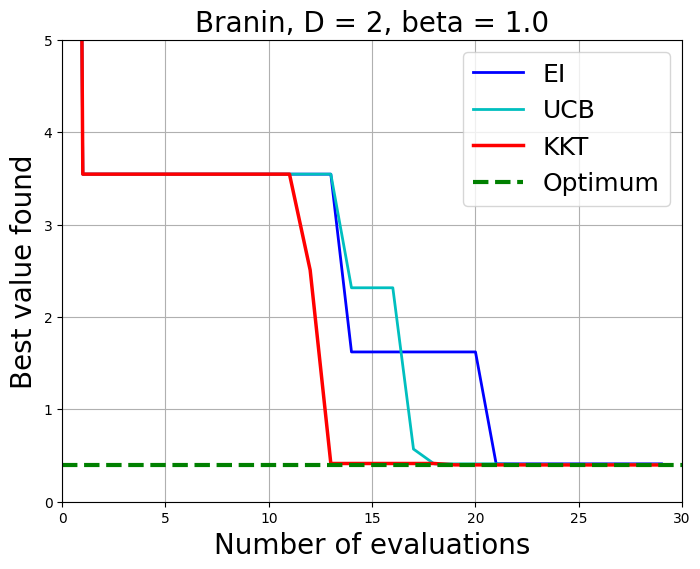

In [ ]:
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import ExpectedImprovement
import matplotlib.pyplot as plt
import numpy as np
import botorch.settings
suppress_botorch_warnings = True

for a in range(num_avg_trials):
  for i, dim in enumerate(dim_list):
    bounds = torch.cat((torch.zeros(1, dim), torch.ones(1, dim))).to(**tkwargs)

    X = SobolEngine(dimension=dim, scramble=True, seed=0).draw(n_init).to(**tkwargs)
    Y = objective[i](X).unsqueeze(-1)
    X_UCB = X.clone()
    Y_UCB = Y.clone()
    Y_grad = compute_grad(X, objective[i])
    X_KKT = X.clone()
    Y_KKT = torch.hstack((Y.clone(), Y_grad))

    for j in range(BO_iter):
      #print general info
      print(f"\n{name_list[i]}, Trial: {a + 1}, Iteration: {j + 1}")

      #expected improvement
      model_list = train_model(X, Y, nu = 2.5)
      #model_list_new = ModelList(*model_list)
      acq_func = ExpectedImprovement(model_list[0], best_f = Y.max())
      candidate, acq_value = optimize_AF(acq_func, bounds)
      X, Y = update_vanilla(X, Y, candidate, "EI")

      #store EI values
      if len(Y)==BO_iter:
        Y_all[a, i, 0] = Y.reshape(BO_iter)

      #upper confidence bound
      model_list = train_model(X_UCB, Y_UCB, nu = 2.5)
      acq_func = UpperConfidenceBound(model_list[0], beta)
      candidate, acq_value = optimize_AF(acq_func, bounds)
      X_UCB, Y_UCB = update_vanilla(X_UCB, Y_UCB, candidate, "UCB")

      if len(Y_UCB) == BO_iter:
        Y_all[a, i, 1] = Y_UCB.reshape(BO_iter)

      #KKT
      model_list = train_model(X_KKT, Y_KKT, nu = 2.5)
      model_list_new = ModelList(*model_list)
      acq_func = ConstrainedUCB(model_list_new, beta, penalty_weight)
      candidate, acq_value = optimize_AF(acq_func, bounds)

      Y_mean_new = objective[i](candidate)
      Y_grad_new = compute_grad(candidate, objective[i]).squeeze()
      Y_new = torch.hstack((Y_mean_new, Y_grad_new))
      X_KKT = torch.vstack((X_KKT, candidate))
      Y_KKT = torch.vstack((Y_KKT, Y_new))
      Y_grad_GP = get_posterior_stats(model_list_new, candidate)[0][0, 1:]
      print("KKT, Best value: ", negate_list[i] * Y_KKT[:, 0].max().item(), ", X: ", candidate, "AF: ", acq_value, ", Y: ", negate_list[i] * Y_mean_new.item(), ", Y grad GP: ", negate_list[i] * Y_grad_GP, ", Y grad query: ", negate_list[i] * Y_grad_new)

      if len(Y_KKT) == BO_iter:
        Y_all[a, i, 2] = Y_KKT[:, 0].reshape(BO_iter)

%matplotlib inline
#average values from the different trials first
Y_all_avg = Y_all.mean(dim = 0)

for i in range(num_test_problems):
  Y_EI_np = negate_list[i] * Y_all_avg[i, 0].cpu().numpy()
  Y_UCB_np = negate_list[i] * Y_all_avg[i, 1].cpu().numpy()
  Y_KKT_np = negate_list[i] * Y_all_avg[i, 2].cpu().numpy()

  fig, ax = plt.subplots(figsize=(8, 6))
  if negate_list[i] < 0:
    ax.plot(np.minimum.accumulate(Y_EI_np), color="b", lw = 2, label="EI")
    ax.plot(np.minimum.accumulate(Y_UCB_np), color="c", lw = 2, label="UCB")
    ax.plot(np.minimum.accumulate(Y_KKT_np), color="r", lw = 2.5, label="KKT")
  elif negate_list[i] > 0:
    ax.plot(np.maximum.accumulate(Y_EI_np), color="b", lw = 2, label="EI")
    ax.plot(np.maximum.accumulate(Y_UCB_np), color="c", lw = 2, label="UCB")
    ax.plot(np.maximum.accumulate(Y_KKT_np), color="r", lw = 2.5, label="KKT")
  ax.plot([0, len(Y_EI_np)], [objective_list[i], objective_list[i]], "--", c="g", lw=3, label="Optimum")

  ax.grid(True)
  ax.set_title(f"{name_list[i]}, D = {dim_list[i]}, beta = {beta}", fontsize=20)
  ax.set_xlabel("Number of evaluations", fontsize=20)
  ax.set_xlim([0, len(Y_EI_np)])
  ax.set_ylabel("Best value found", fontsize=20)
  ax.set_ylim([plot_bounds[i][0], plot_bounds[i][1]])
  ax.legend(fontsize=18)
  plt.show()

In [ ]:
print()